# BERT Triplet model fine-tuning (cls)

## import

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

import pandas as pd
import tensorboard
from sklearn.model_selection import train_test_split

# triplet
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

## resources (config)

In [2]:
# OUTPUT: 저장될 경로, 모델명, 버전 정보
output_dir = 'output' # encoder 모델, log 저장할 상위 폴더
model_name = 'TRI_FT_ORI_TREC_42'
version = 'v2.3'

# INPUT: 기존 BERT base 모델, 데이터 경로
model_ckpt = 'pre-trained_BERT/uncased_L-12_H-768_A-12' # ckpt, vocab 들어있는 폴더 (구글 공식 제공)
dataset = 'dataset/trec' # 데이터 폴더

# 불러올 모델의 이름, epoch, 버전 설정
encoder_name = 'TRI_SUM_TREC_42'
encoder_epoch_num = 17 # 최저 val_loss epoch = 17
encoder_version = 'v2.3'

# 해당 모델의 epcch, batch size 설정
epoch = 10 #FT 모두 10번 할 것
batch_size = 32

# dataset 및 shape 설정
dataset_type = 'TREC_42' # TREC_6 / TREC_42
ftmodel_shape = 'ORI' # ORI / L2 / DENSE_L2

In [3]:
# 폴더 미존재 시 자동 생성함
model_dir = output_dir + '/FT/' + model_name + '/' + version + '/models' # model 저장할 폴더
log_dir = output_dir + '/FT/' + model_name + '/' + version + '/logs'# log 저장할 폴더
my_encoder_ckpt = output_dir + '/' + encoder_name + '/' + encoder_version + '/models/encoder/%s'%encoder_epoch_num

print('==== LOAD ENCODER 경로 ====')
print('load encoder path:', my_encoder_ckpt, '\n')

print('==== OUTPUT 경로 ====')
print('model path:', model_dir)
print('log path:', log_dir)

# 에러 메시지 안띄움
tf.get_logger().setLevel('FATAL')

==== LOAD ENCODER 경로 ====
load encoder path: output/TRI_SUM_TREC_42/v2.3/models/encoder/17 

==== OUTPUT 경로 ====
model path: output/FT/TRI_FT_ORI_TREC_42/v2.3/models
log path: output/FT/TRI_FT_ORI_TREC_42/v2.3/logs


## callback

In [4]:
model_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        bert_classifier.save_weights(model_dir+'/classifier/%d/'%(epoch + 1))
        checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=bert_encoder)
        path = checkpoint.write(model_dir+"/encoder/%d/ckpt"%(epoch + 1))

## datasets

In [5]:
# df 불러오기
temp_train_df = pd.read_csv(dataset+'/trec_train_5500.csv')
test_df = pd.read_csv(dataset+'/trec_test.csv')

In [6]:
if dataset_type == 'TREC_6':
    # 6개짜리로 index 수정
    temp_train_df['Class Index'] = temp_train_df['Class Index'].str.split(':').str[0]
    test_df['Class Index'] = test_df['Class Index'].str.split(':').str[0]

elif dataset_type == 'TREC_42':
    # 클래스 개수 파악
    num_classes = len(temp_train_df['Class Index'].unique())
    print('class개수: %d개'%num_classes)
    print('class목록:',list(temp_train_df['Class Index'].unique()))

    # test에 없는 클래스 파악
    test_list = list(test_df['Class Index'].unique())
    remove_label = []

    for label in list(temp_train_df['Class Index'].unique()):
        if label not in test_list:
            print(label)
            remove_label.append(label)
            
    # test에 없는 클래스 제거
    for remove in remove_label:
        temp_train_df = temp_train_df[temp_train_df['Class Index'] != remove]

    temp_train_df
    
else:
    raise Exception('잘못된 데이터 셋 입력')

class개수: 50개
class목록: ['DESC:manner', 'ENTY:cremat', 'ENTY:animal', 'ABBR:exp', 'HUM:ind', 'HUM:gr', 'HUM:title', 'DESC:def', 'NUM:date', 'DESC:reason', 'ENTY:event', 'LOC:state', 'DESC:desc', 'NUM:count', 'ENTY:other', 'ENTY:letter', 'LOC:other', 'ENTY:religion', 'ENTY:food', 'LOC:country', 'ENTY:color', 'ENTY:termeq', 'LOC:city', 'ENTY:body', 'ENTY:dismed', 'LOC:mount', 'NUM:money', 'ENTY:product', 'NUM:period', 'ENTY:substance', 'ENTY:sport', 'ENTY:plant', 'ENTY:techmeth', 'NUM:volsize', 'HUM:desc', 'ENTY:instru', 'ABBR:abb', 'NUM:other', 'NUM:speed', 'ENTY:word', 'ENTY:lang', 'NUM:perc', 'NUM:code', 'NUM:dist', 'NUM:temp', 'ENTY:symbol', 'NUM:ord', 'ENTY:veh', 'NUM:weight', 'ENTY:currency']
ENTY:cremat
ENTY:letter
ENTY:religion
NUM:volsize
ENTY:word
NUM:code
ENTY:symbol
NUM:ord


In [7]:
# 클래스 개수 파악
num_classes = len(temp_train_df['Class Index'].unique())
print('class개수: %d개'%num_classes)
print('class목록:',list(temp_train_df['Class Index'].unique()))

class개수: 42개
class목록: ['DESC:manner', 'ENTY:animal', 'ABBR:exp', 'HUM:ind', 'HUM:gr', 'HUM:title', 'DESC:def', 'NUM:date', 'DESC:reason', 'ENTY:event', 'LOC:state', 'DESC:desc', 'NUM:count', 'ENTY:other', 'LOC:other', 'ENTY:food', 'LOC:country', 'ENTY:color', 'ENTY:termeq', 'LOC:city', 'ENTY:body', 'ENTY:dismed', 'LOC:mount', 'NUM:money', 'ENTY:product', 'NUM:period', 'ENTY:substance', 'ENTY:sport', 'ENTY:plant', 'ENTY:techmeth', 'HUM:desc', 'ENTY:instru', 'ABBR:abb', 'NUM:other', 'NUM:speed', 'ENTY:lang', 'NUM:perc', 'NUM:dist', 'NUM:temp', 'ENTY:veh', 'NUM:weight', 'ENTY:currency']


In [8]:
# train, validation 분할
train_df = pd.DataFrame(columns = ['Class Index','Sum'])
validation_df = pd.DataFrame(columns = ['Class Index','Sum'])

for label in list(temp_train_df['Class Index'].unique()):
    temp=train_test_split(temp_train_df[temp_train_df['Class Index']==label], shuffle=True, test_size=0.1) # 얘를 true로
    train_df = pd.concat([train_df,temp[0]])
    validation_df = pd.concat([validation_df,temp[1]])
    del temp

del temp_train_df

In [9]:
num = 0
label_dic = {}
for i in list(train_df['Class Index'].unique()):
    label_dic[i] = num
    num+=1

In [10]:
# 필요시 label 수정
train_df['Class Index'] = train_df['Class Index'].replace(label_dic)
test_df['Class Index'] = test_df['Class Index'].replace(label_dic)
validation_df['Class Index'] = validation_df['Class Index'].replace(label_dic)

In [11]:
print('수정된 class목록:',label_dic)

수정된 class목록: {'DESC:manner': 0, 'ENTY:animal': 1, 'ABBR:exp': 2, 'HUM:ind': 3, 'HUM:gr': 4, 'HUM:title': 5, 'DESC:def': 6, 'NUM:date': 7, 'DESC:reason': 8, 'ENTY:event': 9, 'LOC:state': 10, 'DESC:desc': 11, 'NUM:count': 12, 'ENTY:other': 13, 'LOC:other': 14, 'ENTY:food': 15, 'LOC:country': 16, 'ENTY:color': 17, 'ENTY:termeq': 18, 'LOC:city': 19, 'ENTY:body': 20, 'ENTY:dismed': 21, 'LOC:mount': 22, 'NUM:money': 23, 'ENTY:product': 24, 'NUM:period': 25, 'ENTY:substance': 26, 'ENTY:sport': 27, 'ENTY:plant': 28, 'ENTY:techmeth': 29, 'HUM:desc': 30, 'ENTY:instru': 31, 'ABBR:abb': 32, 'NUM:other': 33, 'NUM:speed': 34, 'ENTY:lang': 35, 'NUM:perc': 36, 'NUM:dist': 37, 'NUM:temp': 38, 'ENTY:veh': 39, 'NUM:weight': 40, 'ENTY:currency': 41}


## BERT tokenizer

In [12]:
# vocab 불러와서 tokenizer 생성
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(model_ckpt, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [13]:
# 위의 과정을 합친 것으로, 함수 두 개 선언
# 쪼개고, 뒤에 [SEP] 붙이고 ids로 변환
def encode_sentence(s, tokenizer): 
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

# 실제 문장들에 위 함수 적용하고, 맨 앞에 CLS 붙여줌
def bert_encode(df_column, tokenizer): 
#   num_examples = len(df_column)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(df_column)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1], axis=-1)

# 실제 텍스트인 부분을 1로 바꿔줌 (텍스트 및 패딩 영역 시각화)
  input_mask = tf.ones_like(input_word_ids).to_tensor()

    # cls~sentence1은 0으로, sentence2는 1로 변경 (시각화)
  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor(1)

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids
      }

  return inputs

In [14]:
# tokenizer 적용
test = bert_encode(test_df['Sum'], tokenizer)
test_labels = tf.convert_to_tensor(test_df['Class Index'],dtype=tf.float64)
print('test tokenize 완료')

validation = bert_encode(validation_df['Sum'], tokenizer)
validation_labels = tf.convert_to_tensor(validation_df['Class Index'],dtype=tf.float64)
print('validation tokenize 완료')

train = bert_encode(train_df['Sum'], tokenizer)
train_labels = tf.convert_to_tensor(train_df['Class Index'],dtype=tf.float64)
print('train tokenize 완료')

test tokenize 완료
validation tokenize 완료
train tokenize 완료


In [15]:
# 출력 필수는 아니지만.. (잘 됐는지 여부나 확인하자)
for key, value in train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'train_labels shape: {train_labels.shape}')

input_word_ids  shape: (4629, 41)
input_mask      shape: (4629, 41)
input_type_ids  shape: (4629, 41)
train_labels shape: (4629,)


## 모델
### (1) 모델 구성 다운로드
사전학습된 모델의 구성 다운로드

In [16]:
import json

bert_config_file = os.path.join(model_ckpt, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

### (2) ENCODER 모델 shape에 따라 모델 구축 및 가중치 로드

In [17]:
if ftmodel_shape == 'ORI': # ORIGINAL인 경우
    # 1_ bert_encoder, classifier 둘 다 불러옴
    bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=num_classes)
    
    # 불러온 모델 시각화는?
    
    # 초기 출력값
    initial_encoder = bert_encoder(bert_encode(['hi my','name hj'],tokenizer))
    initial_classifier = bert_classifier.predict(bert_encode(['hi my','name hj'],tokenizer))
    
    # 가중치 복원 (내가 학습시킨 encoder)
    checkpoint = tf.train.Checkpoint(model=bert_encoder)
    checkpoint.restore(os.path.join(my_encoder_ckpt, 'ckpt')).expect_partial()
    
    # 복원 후 출력값
    real_encoder = bert_encoder(bert_encode(['hi my','name hj'],tokenizer))
    real_classifier = bert_classifier.predict(bert_encode(['hi my','name hj'],tokenizer))
    
    # temp encoder 생성 (encoder 학습 시의 구조 복원)
    from tensorflow.keras.layers import Lambda, Dense

    x = bert_encoder.layers[-1].output
    outputs = Lambda(lambda x: tf.math.l2_normalize(x,axis=1))(x)
    bert_encoder_test = tf.keras.Model(bert_encoder.input, outputs)

    test_encoder = bert_encoder_test(bert_encode(['hi my','name hj'],tokenizer))
    del bert_encoder_test # 다 썼으면 버려
    
    # encoder끼리 다르고, classifier끼리 달라야 함
    print('=== Checklist 1 : 하단 encoder 및 classifier 값이 다른지 ===')
    
    if not np.array_equal(initial_encoder[0],real_encoder[0]) and not np.array_equal(initial_encoder[1],real_encoder[1]):
        print('(1) encoder 가중치 복원 성공 ✨')
    else:
        raise Exception('encoder 가중치 복원 실패')
        
    if not np.array_equal(initial_classifier[0],real_classifier[0]) and not np.array_equal(initial_classifier[1],real_classifier[1]):
        print('(2) classifier 연결 성공 ✨ \n')   
    else:
        raise Exception('classifier 연결 실패')
        
    print('=== Checklist 2 : 하단 encoder 값이 pretrain 시의 값과 같은지 (last epoch인 경우만!) ===')
    print(test_encoder)
    
elif ftmodel_shape == 'L2':
    print('--')

elif ftmodel_shape == 'DENSE_L2':
    print('--')

else:
    raise Exception('잘못된 model shape 입력')

=== Checklist 1 : 하단 encoder 및 classifier 값이 다른지 ===
(1) encoder 가중치 복원 성공 ✨
(2) classifier 연결 성공 ✨ 

=== Checklist 2 : 하단 encoder 값이 pretrain 시의 값과 같은지 (last epoch인 경우만!) ===
tf.Tensor(
[[-0.04521042 -0.00845004 -0.03835804 ...  0.00937658 -0.04423252
   0.0525574 ]
 [-0.02941011 -0.03656969 -0.0433353  ... -0.04169269 -0.0394551
   0.033793  ]], shape=(2, 768), dtype=float32)


### 값 확인을 원한다면

In [18]:
if ftmodel_shape == 'ORI': # ORIGINAL인 경우
    print('(1) encoder')
    print('\ninitial encoder'+'='*10)
    print(initial_encoder)
    print('\nreal encoder:'+'='*10)
    print(real_encoder)

    print('\n\n(2) classifier')
    print('\ninitial classifier:'+'='*10)
    print(initial_classifier)
    print('\nreal classifier:'+'='*10)
    print(real_classifier)
    
elif ftmodel_shape == 'L2':
    print('--')

elif ftmodel_shape == 'DENSE_L2':
    print('--')

else:
    raise Exception('잘못된 model shape 입력')

(1) encoder

initial encoder==========
[<tf.Tensor: shape=(2, 1, 768), dtype=float32, numpy=
array([[[-1.2054819 ,  0.34670165,  1.1819605 , ...,  1.3357555 ,
         -1.5554322 , -0.64482343]],

       [[-1.5116467 , -0.00452171,  1.0792621 , ...,  1.272426  ,
         -1.4472915 , -0.53344655]]], dtype=float32)>, <tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.10780464,  0.7742011 ,  0.19324581, ...,  0.11383574,
        -0.2828127 ,  0.87296265],
       [-0.23952024,  0.8248466 ,  0.19055977, ...,  0.08590854,
        -0.17058446,  0.7554058 ]], dtype=float32)>]

real encoder:==========
[<tf.Tensor: shape=(2, 1, 768), dtype=float32, numpy=
array([[[-1.304445  ,  0.50308853, -0.20609869, ...,  0.70788825,
         -0.57860595,  0.9847571 ]],

       [[-0.83099   ,  0.18827663, -0.48567125, ..., -1.1817669 ,
         -0.7015257 , -0.16534434]]], dtype=float32)>, <tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.78241605, -0.14623718, -0.6638281 , ...,  0.16227

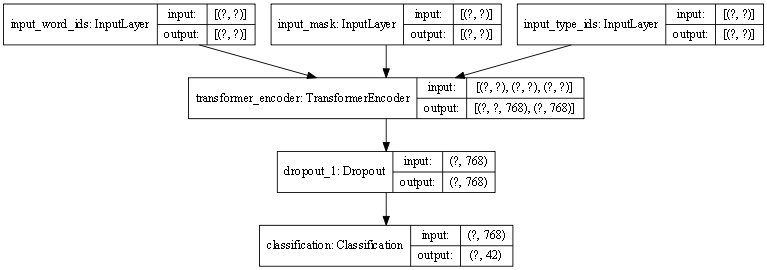

In [19]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=64)

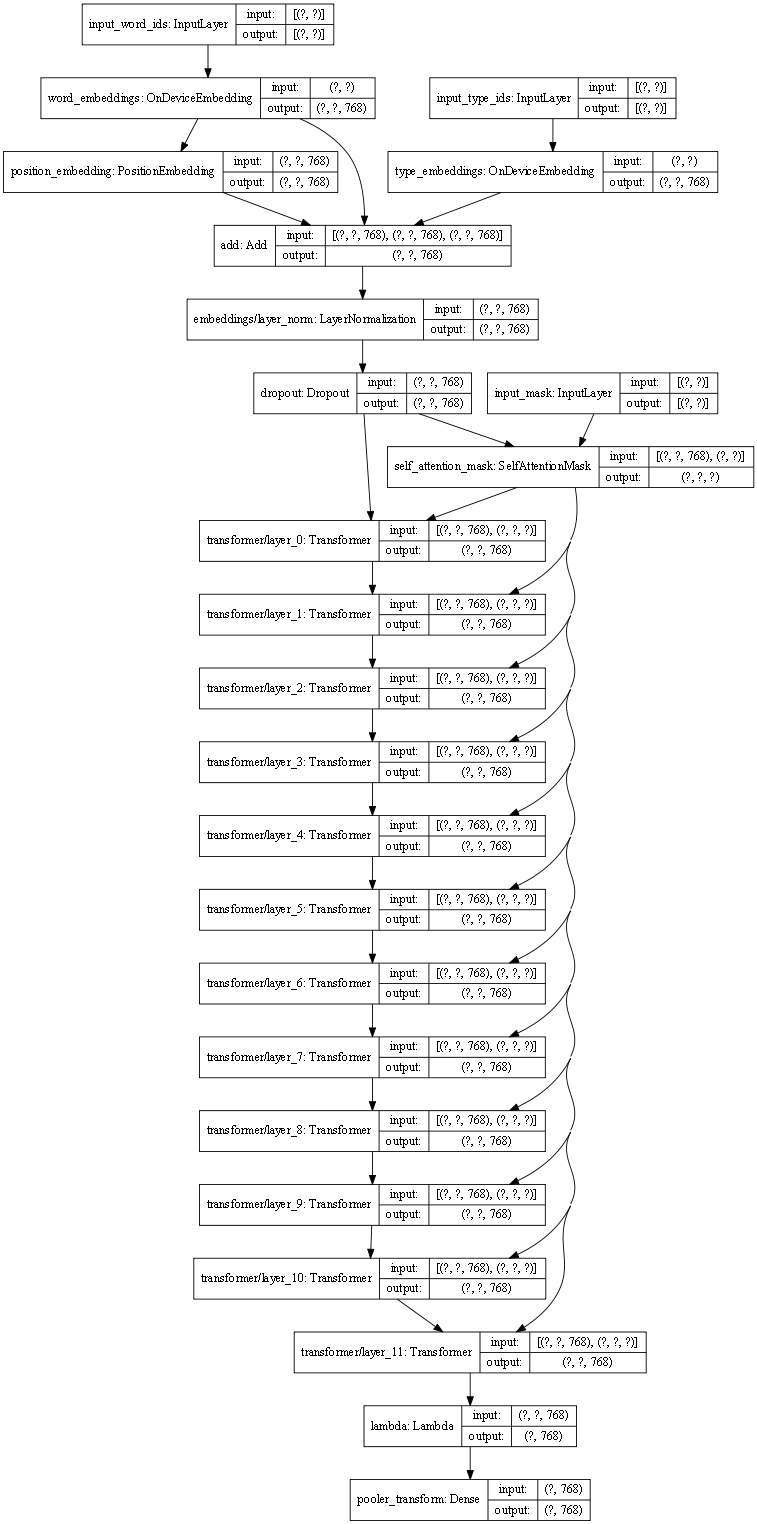

In [20]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=64)

### (3) 최적화 프로그램 설정

In [21]:
# BERT는 가중치 감소 ( " AdamW "라고도 함)가있는 Adam 최적화 프로그램을 채택합니다. 또한 먼저 0에서 워밍업 한 다음 0으로 감소하는 학습률 일정을 사용합니다.

# Set up epochs and steps
eval_batch_size = batch_size 

train_data_size = len(train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epoch
warmup_steps = int(epoch * train_data_size * 0.1 / batch_size) 

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [22]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [23]:
train_data_size

4629

### (4) 모델 훈련

In [24]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      train, train_labels,
      validation_data=(validation, validation_labels),
      batch_size=batch_size,
      epochs=epoch,
      callbacks = [model_tensorboard, CustomCallback()]) 

Epoch 1/10
145/145 [==============================] - 40s 278ms/step - loss: 2.8970 - accuracy: 0.4684 - val_loss: 1.5587 - val_accuracy: 0.8494
Epoch 2/10
145/145 [==============================] - 38s 262ms/step - loss: 1.0649 - accuracy: 0.8963 - val_loss: 0.7027 - val_accuracy: 0.9126
Epoch 3/10
145/145 [==============================] - 37s 257ms/step - loss: 0.5749 - accuracy: 0.9423 - val_loss: 0.4650 - val_accuracy: 0.9405
Epoch 4/10
145/145 [==============================] - 37s 258ms/step - loss: 0.3798 - accuracy: 0.9654 - val_loss: 0.3613 - val_accuracy: 0.9517
Epoch 5/10
145/145 [==============================] - 37s 256ms/step - loss: 0.2864 - accuracy: 0.9782 - val_loss: 0.2802 - val_accuracy: 0.9647
Epoch 6/10
145/145 [==============================] - 37s 257ms/step - loss: 0.2243 - accuracy: 0.9834 - val_loss: 0.2428 - val_accuracy: 0.9684
Epoch 7/10
145/145 [==============================] - 38s 260ms/step - loss: 0.1901 - accuracy: 0.9875 - val_loss: 0.2240 - val_ac